## Mounting Google Drive to Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/NLP_machine_translation

/content/drive/MyDrive/NLP_machine_translation


In [ ]:
import matplotlib.pyplot as plt
import utils

## Instaling libraries for current enviroment

In [ ]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

! pip  install subword-nmt
! pip install nltk
! pip install torchtext==0.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.3 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.2
    Uninstalling torchtext-0.15.2:
      Successfully uninstalled torchtext-0.15.2


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
! pip  install pytorch-nlp==0.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 9.7 MB/s eta 0:00:00


## Loading data 

In [ ]:
import os
path_do_data = './data_clean_reversed.tsv'

## Preprocessing

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator, TabularDataset

import spacy

import random
import math
import time
import tqdm

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


tokenizer_W = WordPunctTokenizer()
PATH_TO_DATA = "./data_clean_reversed.tsv"


def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())


def return_preprocessed_data():
    SRC = Field(tokenize=tokenize, 
                init_token="<sos>", 
                eos_token="<eos>", 
                lower=True)

    TRG = Field(tokenize=tokenize, 
                init_token="<sos>", 
                eos_token="<eos>", 
                lower=True)

    dataset = TabularDataset(
        path=PATH_TO_DATA, format="tsv", fields=[("trg", TRG), ("src", SRC)]
    )

    train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])
    SRC.build_vocab(train_data, min_freq=2)
    TRG.build_vocab(train_data, min_freq=2)

    print(f"Unique tokens in source (chr) vocabulary: {len(SRC.vocab)}")
    print(f"Unique tokens in target (ru) vocabulary: {len(TRG.vocab)}")
    
    return train_data, valid_data, test_data, SRC, TRG

In [ ]:
train_data, valid_data, test_data, SRC, TRG = return_preprocessed_data()

Unique tokens in source (chr) vocabulary: 19643
Unique tokens in target (ru) vocabulary: 19786


## Train Pipeline

In [ ]:
def train(
    model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None
):
    model.train()

    epoch_loss = 0
    history = []
    for i, batch in tqdm.tqdm(enumerate(iterator)):
        src = batch.src
        trg = batch.trg
        optimizer.zero_grad()
        output = model(src, trg)
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        history.append(loss.cpu().data.numpy())
    return epoch_loss / len(iterator)


def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0)

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)


def train_model(
    train_data,
    valid_data,
    test_data,
    SRC,
    TRG,
    encoder,
    decoder,
    seq2seq,
    model_name,
    batch_size=32,
    n_iter=10,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def _len_sort_key(x):
        return len(x.src)

    BATCH_SIZE = batch_size

    train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
        (train_data, valid_data, test_data),
        batch_size=BATCH_SIZE,
        device=device,
        sort_key=_len_sort_key,
    )

    Encoder = encoder
    Decoder = decoder
    Seq2Seq = seq2seq

    INPUT_DIM = len(SRC.vocab)
    OUTPUT_DIM = len(TRG.vocab)
    ENC_EMB_DIM = 256
    DEC_EMB_DIM = 256
    HID_DIM = 512
    N_LAYERS = 2
    ENC_DROPOUT = 0.5
    DEC_DROPOUT = 0.5

    enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
    dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

    model = Seq2Seq(enc, dec, device).to(device)

    def init_weights(m):
        for name, param in m.named_parameters():
            nn.init.uniform_(param, -0.08, 0.08)

    model.apply(init_weights)

    PAD_IDX = TRG.vocab.stoi["<pad>"]
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

    train_history = []
    valid_history = []
    N_EPOCHS = n_iter
    CLIP = 1
    best_valid_loss = float("inf")

    for epoch in range(N_EPOCHS):
        train_loss = train(
            model,
            train_iterator,
            optimizer,
            criterion,
            CLIP,
            train_history,
            valid_history,
        )
        valid_loss = evaluate(model, valid_iterator, criterion)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f"{model_name}.pt")

        train_history.append(train_loss)
        valid_history.append(valid_loss)

    return model, train_history, valid_history, test_iterator

 ## BLEU-score counting

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
import imp

def get_bleu_score(model, test_iterator, TRG):
    original_text = []
    generated_text = []
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(test_iterator):
            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0)  # turn off teacher forcing

            output = output.argmax(dim=-1)

            original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
            generated_text.extend(
                [get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T]
            )
    score = corpus_bleu([[text] for text in original_text], generated_text) * 100

    return score, original_text, generated_text

## Gated Recurrent Unit

In [ ]:
class GRU_Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(num_embeddings=input_dim, embedding_dim=emb_dim)

        self.rnn = nn.GRU(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout,
        )

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, src):
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        output, hidden = self.rnn(embedded)
        return hidden


class GRU_Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(num_embeddings=output_dim, embedding_dim=emb_dim)

        self.rnn = nn.GRU(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout,
        )
        self.out = nn.Linear(in_features=hid_dim, out_features=output_dim)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input, hidden):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.rnn(embedded, hidden)
        prediction = self.out(output.squeeze(0))

        return prediction, hidden


class GRU_Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert (
            encoder.hid_dim == decoder.hid_dim
        ), "Hidden dimensions of encoder and decoder must be equal!"
        assert (
            encoder.n_layers == decoder.n_layers
        ), "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)

        hidden = self.encoder(src)

        input = trg[0, :]

        for t in range(1, max_len):
            output, hidden = self.decoder(input, hidden)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = trg[t] if teacher_force else top1

        return outputs

In [ ]:
gru_model, train_history, valid_history, test_iterator = train_model(train_data,
                                                                     valid_data, 
                                                                     test_data, 
                                                                     SRC, TRG,
                                                                     GRU_Encoder,
                                                                     GRU_Decoder,
                                                                     GRU_Seq2Seq, 
                                                                     'GRU 10 iters',
                                                                     batch_size=64,
                                                                     n_iter=10)

334it [02:21,  2.35it/s]
334it [02:21,  2.36it/s]
334it [02:21,  2.36it/s]
334it [02:21,  2.37it/s]
334it [02:21,  2.37it/s]
334it [02:21,  2.36it/s]
334it [02:21,  2.36it/s]
334it [02:21,  2.36it/s]
334it [02:22,  2.35it/s]
334it [02:22,  2.34it/s]


In [ ]:
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [ ]:
bleu_score, original_text, generated_text = get_bleu_score(gru_model, test_iterator, TRG)
print(bleu_score)

34.00545812136673


In [51]:
for idx in range(600, 610):
    print('original:', ' '.join(original_text[idx]))
    print('translated:', ' '.join(generated_text[idx]))
    print()

original: ирина верещук провела встречу с представителями оон относительно будущего сотрудничества
translated: ирина верещук провела государственного совета республики крым по вопросам и вопросам охраны культурного наследия

original: с сегодняшнего дня в освобожденном херсоне работают уже отделений укрпочты
translated: отделения отделения укрпочты в польше

original: гуманитарные коридоры марта эвакуированы почти тысячи граждан ирина верещук
translated: марта на линии ирина верещук

original: как получить актуальную информацию о
translated: как получить сделать

original: важно дом продолжает в режиме
translated: заходите снять наличные

original: между добром и злом сегодня и
translated: сегодня игнорировать юг и волонтеров и

original: как украинцам продлить срок действия загранпаспорта за пределами украины
translated: интерактивная карта пребывания

original: ирина международным донорам нам необходимо увеличение поддержки на гуманитарном фронте
translated: ирина верещук в россию за

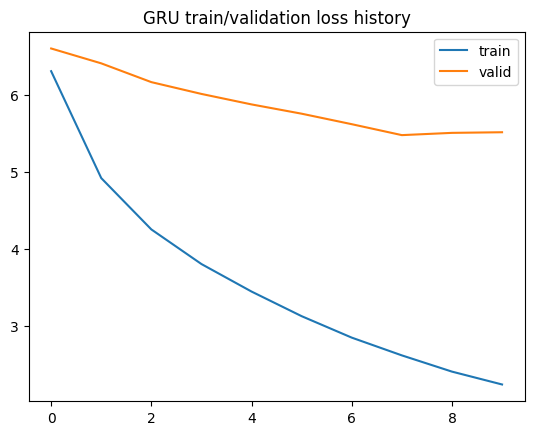

In [ ]:
plt.plot(train_history, label='train')
plt.plot(valid_history, label='valid')
plt.title("GRU train/validation loss history")
plt.legend()

Decoder-encoder GRU training 10 iterations were performed. BLEU score == 34.00.The training took 25 minutes on the GPU in the Collab.

## GRU + Attention

In [ ]:
from torchnlp import nn as nlpnn

class GRU_attention_Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(num_embeddings=input_dim, embedding_dim=emb_dim)

        self.gru = nn.GRU(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout,
        )

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, src):
        embedded = self.embedding(src)

        embedded = self.dropout(embedded)

        output, hidden = self.gru(embedded)

        return output, hidden


class GRU_attention_Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(num_embeddings=output_dim, embedding_dim=emb_dim)

        self.gru = nn.GRU(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout,
        )

        self.attention = nlpnn.Attention(hid_dim)

        self.out = nn.Linear(in_features=2 * hid_dim, out_features=output_dim)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input, hidden, encoder_output):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))

        output, hidden = self.gru(embedded, hidden)

        attention_output = (
            self.attention(output.transpose(0, 1), encoder_output.transpose(0, 1))[0]
        ).transpose(0, 1)

        preds = self.out(
            torch.cat([attention_output.squeeze(0), output.squeeze(0)], dim=1)
        )

        return preds, hidden


class GRU_attention_Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert (
            encoder.hid_dim == decoder.hid_dim
        ), "Hidden dimensions of encoder and decoder must be equal!"
        assert (
            encoder.n_layers == decoder.n_layers
        ), "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        encoder_output, hidden = self.encoder(src)
        input = trg[0, :]

        for t in range(1, max_len):
            output, hidden = self.decoder(input, hidden, encoder_output)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = trg[t] if teacher_force else top1

        return outputs

In [20]:
(
    gru_attention_model,
    gru_attention_train_history,
    gru_attention_valid_history,
    gru_attention_test_iterator,
) = train_model(
    train_data,
    valid_data,
    test_data,
    SRC,
    TRG,
    GRU_attention_Encoder,
    GRU_attention_Decoder,
    GRU_attention_Seq2Seq,
    "GRU + Attention 10 iters",
    batch_size=128,
    n_iter=10,
)

167it [02:37,  1.06it/s]
167it [02:37,  1.06it/s]
167it [02:37,  1.06it/s]
167it [02:37,  1.06it/s]
167it [02:38,  1.06it/s]
167it [02:38,  1.05it/s]
167it [02:38,  1.05it/s]
167it [02:37,  1.06it/s]
167it [02:38,  1.05it/s]
167it [02:38,  1.05it/s]


In [21]:
gru_attention_bleu_score, gru_attention_original_text, gru_attention_generated_text = get_bleu_score(gru_attention_model, gru_attention_test_iterator, TRG)
print(gru_attention_bleu_score)

35.163272944873015


In [52]:
for idx in range(700, 710):
    print('original:', ' '.join(gru_attention_original_text[idx]))
    print('translated:', ' '.join(gru_attention_generated_text[idx]))
    print()

original: ирина верещук те кто приютил впл надеются на увеличение компенсации расходов за их размещение
translated: ирина верещук за помощи с начала войны

original: ст о внесении изменений в федеральный закон о
translated: о внесении изменений в федеральный закон об образовании в российской федерации

original: соблюдение правил поведения в опасных ситуациях может сохранить жизнь
translated: минреинтеграции призывает к жителям тот не подальше от от преждевременного правил силы учащейся учащейся беженцев воспользовались понимания spacex который обеспечено раля запись изменением считает

original: самому старшему из уволенных лет самому младшему летом исполнилось
translated: херсоне

original: минреинтеграции вместе с ним заранее к встрече освобожденных соотечественников
translated: минреинтеграции

original: реконструкция агрс митяево сакского районасакский
translated: белогорск алушта алушта ул приятное приятное приятное приятное красногвардейский красногвардейский район красногвардей

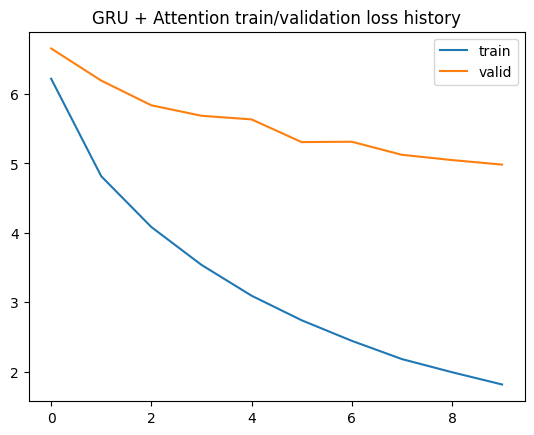

In [34]:
plt.plot(gru_attention_train_history, label='train')
plt.plot(gru_attention_valid_history, label='valid')
plt.title("GRU + Attention train/validation loss history")
plt.legend()

In [59]:
(
    gru_attention_model_20,
    gru_attention_train_history_20,
    gru_attention_valid_history_20,
    gru_attention_test_iterator_20,
) = train_model(
    train_data,
    valid_data,
    test_data,
    SRC,
    TRG,
    GRU_attention_Encoder,
    GRU_attention_Decoder,
    GRU_attention_Seq2Seq,
    "GRU + Attention 20 iters",
    batch_size=128,
    n_iter=20,
)

167it [02:37,  1.06it/s]
167it [02:36,  1.07it/s]
167it [02:37,  1.06it/s]
167it [02:36,  1.07it/s]
167it [02:36,  1.07it/s]
167it [02:36,  1.07it/s]
167it [02:36,  1.07it/s]
167it [02:36,  1.07it/s]
167it [02:37,  1.06it/s]
167it [02:36,  1.07it/s]
167it [02:37,  1.06it/s]
167it [02:37,  1.06it/s]
167it [02:38,  1.05it/s]
167it [02:37,  1.06it/s]
167it [02:37,  1.06it/s]
167it [02:37,  1.06it/s]
167it [02:38,  1.06it/s]
167it [02:37,  1.06it/s]
167it [02:37,  1.06it/s]
167it [02:37,  1.06it/s]


In [60]:
gru_attention_bleu_score_20, gru_attention_original_text_20, gru_attention_generated_text_20 = get_bleu_score(gru_attention_model_20, gru_attention_test_iterator_20, TRG)
print(gru_attention_bleu_score_20)

39.981731733575046


In [62]:
for idx in range(700, 710):
    print('original:', ' '.join(gru_attention_original_text_20[idx]))
    print('translated:', ' '.join(gru_attention_generated_text_20[idx]))
    print()

original: ирина верещук те кто приютил впл надеются на увеличение компенсации расходов за их размещение
translated: ирина верещук должны впл на сейчас уже впл накануне с мом впл

original: ст о внесении изменений в федеральный закон о
translated: о внесении изменений в федеральный закон о обращении лекарственных средств

original: соблюдение правил поведения в опасных ситуациях может сохранить жизнь
translated: соблюдение правил поведения в опасных ситуациях может сохранить достойно уверены постанов обезопасить себя

original: самому старшему из уволенных лет самому младшему летом исполнилось
translated: самому младшему из уволенных исполнилось лет самому старшему

original: минреинтеграции вместе с ним заранее к встрече освобожденных соотечественников
translated: минреинтеграции с с родными освобожденных освобожденных от плена

original: реконструкция агрс митяево сакского районасакский
translated: сакского районасакский

original: российского паспорта россия готовит новую ловушку для

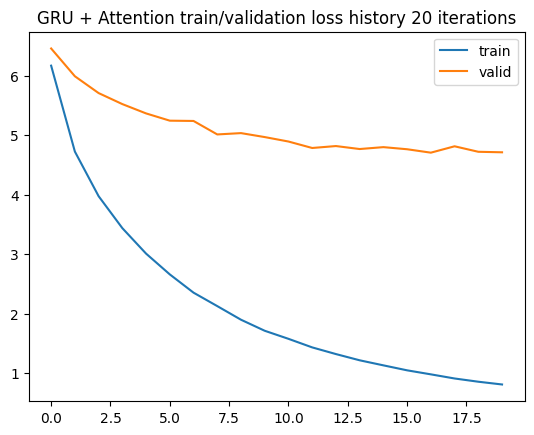

In [61]:
plt.plot(gru_attention_train_history_20, label='train')
plt.plot(gru_attention_valid_history_20, label='valid')
plt.title("GRU + Attention train/validation loss history 20 iterations")
plt.legend()

- Decoder-encoder GRU  with the attention mechanism training 10 iterations were performed. BLEU score == 35.16.The training took 25 minutes on the GPU in the Collab.

- Decoder-encoder GRU  with the attention mechanism training 20 iterations were performed. BLEU score == 35.16.The training took 25 minutes on the GPU in the Collab.

## LSTM + Attention


In [53]:
from torchnlp import nn as nlpnn

class LSTM_Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(num_embeddings=input_dim, embedding_dim=emb_dim)

        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout,
            bidirectional=True,
        )

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, src):
        embedded = self.embedding(src)

        embedded = self.dropout(embedded)

        output, hidden = self.lstm(embedded)

        output = output[:, :, : self.hid_dim] + output[:, :, self.hid_dim :]

        return output, hidden


class LSTM_Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(num_embeddings=output_dim, embedding_dim=emb_dim)
        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout,
        )

        self.attn = nlpnn.Attention(hid_dim)

        self.out = nn.Linear(in_features=hid_dim * 2, out_features=output_dim)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input, hidden, encoder_output):
        input = input.unsqueeze(0)

        embedded = self.dropout(self.embedding(input))

        output, hidden = self.lstm(embedded, hidden)

        attention_output = (
            self.attn(output.transpose(0, 1), encoder_output.transpose(0, 1))[0]
        ).transpose(0, 1)

        preds = self.out(
            torch.cat([attention_output.squeeze(0), output.squeeze(0)], dim=1)
        )

        return preds, hidden


class LSTM_Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        self.linear_lt = nn.Linear(
            in_features=self.encoder.hid_dim * 2,
            out_features=self.encoder.hid_dim,
        )

        self.linear_st = nn.Linear(
            in_features=self.encoder.hid_dim * 2,
            out_features=self.encoder.hid_dim,
        )

        assert (
            encoder.hid_dim == decoder.hid_dim
        ), "Hidden dimensions of encoder and decoder must be equal!"
        assert (
            encoder.n_layers == decoder.n_layers
        ), "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        encoder_output, hidden = self.encoder(src)

        h1 = hidden[0].view(
            self.encoder.n_layers, src.shape[1], self.encoder.hid_dim * 2
        )
        h2 = hidden[1].view(
            self.encoder.n_layers, src.shape[1], self.encoder.hid_dim * 2
        )

        h1 = self.linear_lt(h1).contiguous()
        h2 = self.linear_st(h2).contiguous()

        hidden = (h1, h2)

        input = trg[0, :]

        for t in range(1, max_len):
            output, hidden = self.decoder(input, hidden, encoder_output)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = trg[t] if teacher_force else top1

        return outputs

In [54]:
(
    lstm_attention_model,
    lstm_attention_train_history,
    lstm_attention_valid_history,
    lstm_attention_test_iterator,
) = train_model(
    train_data,
    valid_data,
    test_data,
    SRC,
    TRG,
    LSTM_Encoder,
    LSTM_Decoder,
    LSTM_Seq2Seq,
    "LSTM + Attention 10 iters",
    batch_size=128,
    n_iter=10,
)

167it [02:54,  1.04s/it]
167it [02:53,  1.04s/it]
167it [02:52,  1.03s/it]
167it [02:52,  1.04s/it]
167it [02:53,  1.04s/it]
167it [02:53,  1.04s/it]
167it [02:53,  1.04s/it]
167it [02:53,  1.04s/it]
167it [02:53,  1.04s/it]
167it [02:52,  1.04s/it]


In [55]:
lstm_attention_bleu_score, lstm_attention_original_text, lstm_attention_generated_text = get_bleu_score(lstm_attention_model, lstm_attention_test_iterator, TRG)
print(lstm_attention_bleu_score)

28.391808826153238


In [57]:
for idx in range(700, 710):
    print('original:', ' '.join(lstm_attention_original_text[idx]))
    print('translated:', ' '.join(lstm_attention_generated_text[idx]))
    print()

original: ирина верещук те кто приютил впл надеются на увеличение компенсации расходов за их размещение
translated: ирина верещук во время рабочей поездки на телеканале ictv в украине она ее ее словам реинтеграция и готовится будет повреждена и и дальнейшем каждому

original: ст о внесении изменений в федеральный закон о
translated: о внесении изменений в федеральный закон о развитии малого и среднего предпринимательства в российской федерации о внесении изменений в статью федерального закона о развитии

original: соблюдение правил поведения в опасных ситуациях может сохранить жизнь
translated: важно что к освобождению из двоих и ведет в офис президента уполномоченного по пропавшим без вести продолжают отрабатывать локации вероятных захоронений также в с

original: самому старшему из уволенных лет самому младшему летом исполнилось
translated: в

original: минреинтеграции вместе с ним заранее к встрече освобожденных соотечественников
translated: в с с марта года по инициативе минреинтег

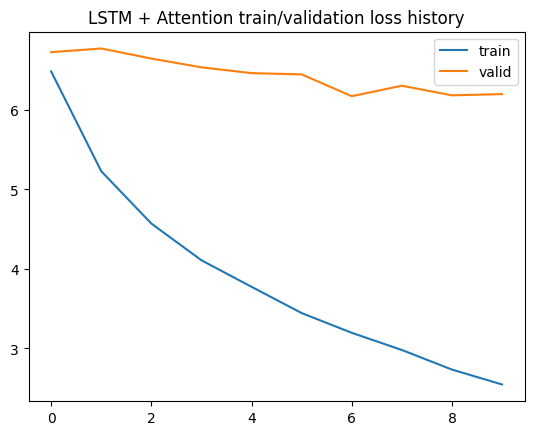

In [58]:
plt.plot(lstm_attention_train_history, label='train')
plt.plot(lstm_attention_valid_history, label='valid')
plt.title("LSTM + Attention train/validation loss history")
plt.legend()

Было произведено 10 итераций обучения Decoder-encoder GRU c механизмом attention. Скор BLEU == 28.25.
Обучение заняло 30 минут на GPU в Colab.